In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from dataclasses import dataclass
from pathlib import Path
import yaml

from omegaconf import OmegaConf, DictConfig
import pandas as pd
from matplotlib import transforms
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import torch
from tqdm.auto import tqdm

from src.analysis.state_space import StateSpaceAnalysisSpec
from src.analysis.trf import coefs_to_df
from src.encoding.ecog.timit import OutFile
from src.encoding.ecog import timit as timit_encoding, get_electrode_df, \
     AlignedECoGDataset, ContrastiveModelSnapshot, epoch_by_state_space
from src.viz.epoching import plot_epoch_raster

In [33]:
dataset = "timit-no_repeats"
study_models = [
    "random8",
    "phoneme",
    "biphone_pred",
    "biphone_recon",
    "next_phoneme",
    "syllable",
    "word_broad-aniso2-w2v2_8",
]
ttest_results_path = f"outputs/encoder_comparison_across_subjects/{dataset}/ttest.csv"
scores_path = f"outputs/encoder_comparison_across_subjects/{dataset}/scores.csv"


encoder_dirs = list(Path("outputs/encoders").glob(f"{dataset}/*/*"))
unique_variance_paths = list(Path(f"outputs/encoder_unique_variance/{dataset}/baseline").glob("*/unique_variance.csv"))

pval_threshold = 1e-3

In [34]:
scores_df = pd.read_csv(scores_path, index_col=["dataset", "subject", "model2", "model1"]).loc[dataset]
if study_models is None:
    study_models = sorted(scores_df.index.get_level_values("model2").unique())
else:
    scores_df = scores_df.loc[scores_df.index.get_level_values("model2").isin(study_models)]
scores_df

electrode_name  \
subject model2                   model1                    
EC152   phoneme                  baseline             G1   
                                 baseline             G1   
                                 baseline             G1   
                                 baseline             G2   
                                 baseline             G2   
...                                                  ...   
EC260   word_broad-aniso2-w2v2_8 baseline          TG127   
                                 baseline          TG127   
                                 baseline          TG128   
                                 baseline          TG128   
                                 baseline          TG128   

                                                              model  \
subject model2                   model1                               
EC152   phoneme                  baseline                  baseline   
                                 baseline                  baseline   
                                 baseline                  baseline   
                                 baseline                  baseline   
                                 baseline                  baseline   
...                                                             ...   
EC260   word_broad-aniso2-w2v2_8 baseline  word_broad-aniso2-w2v2_8   
                                 baseline  word_broad-aniso2-w2v2_8   
                                 baseline  word_broad-aniso2-w2v2_8   
                                 baseline  word_broad-aniso2-w2v2_8   
                                 baseline  word_broad-aniso2-w2v2_8   

                                           output_dim  fold     score  \
subject model2                   model1                                 
EC152   phoneme                  baseline           0     0 -0.001135   
                                 baseline           0     1 -0.001564   
                                 baseline           0     2 -0.007084   
                                 baseline           1     0  0.001129   
                                 baseline           1     1  0.002411   
...                                               ...   ...       ...   
EC260   word_broad-aniso2-w2v2_8 baseline         254     1  0.060345   
                                 baseline         254     2  0.047571   
                                 baseline         255     0  0.075873   
                                 baseline         255     1  0.054914   
                                 baseline         255     2  0.046319   

                                              output_name  
subject model2                   model1                    
EC152   phoneme                  baseline       (0, 'G1')  
                                 baseline       (0, 'G1')  
                                 baseline       (0, 'G1')  
                                 baseline       (1, 'G2')  
                                 baseline       (1, 'G2')  
...                                                   ...  
EC260   word_broad-aniso2-w2v2_8 baseline  (254, 'TG127')  
                                 baseline  (254, 'TG127')  
                                 baseline  (255, 'TG128')  
                                 baseline  (255, 'TG128')  
                                 baseline  (255, 'TG128')  

[69888 rows x 6 columns]

In [35]:
ttest_df = pd.read_csv(ttest_results_path, index_col=["dataset", "subject", "model2", "model1", "output_dim"]) \
    .loc[dataset].loc[(slice(None), study_models), :]
ttest_df["log_pval"] = np.log10(ttest_df["pval"])
ttest_df

Unnamed: 4 permutation  \
subject model2                   model1   output_dim                           
EC152   random8                  baseline 165                  0       shift   
                                          116                  1       shift   
                                          129                  2       shift   
                                          133                  3       shift   
                                          101                  4       shift   
...                                                          ...         ...   
EC260   word_broad-aniso2-w2v2_8 baseline 169                107       shift   
                                          191                108       shift   
                                          94                 109       shift   
                                          114                110       shift   
                                          219                111       units   

                                                           tval          pval  \
subject model2                   model1   output_dim                            
EC152   random8                  baseline 165         64.420931  3.478131e-07   
                                          116         20.962180  3.060871e-05   
                                          129         20.348246  3.444157e-05   
                                          133         20.327161  3.458355e-05   
                                          101         19.955432  3.721096e-05   
...                                                         ...           ...   
EC260   word_broad-aniso2-w2v2_8 baseline 169          1.025800  3.629666e-01   
                                          191          0.871193  4.328148e-01   
                                          94          -0.734340  5.034666e-01   
                                          114         -0.056520  9.576384e-01   
                                          219         -0.001985  9.985112e-01   

                                                      log_pval  
subject model2                   model1   output_dim            
EC152   random8                  baseline 165        -6.458654  
                                          116        -4.514155  
                                          129        -4.462917  
                                          133        -4.461130  
                                          101        -4.429329  
...                                                        ...  
EC260   word_broad-aniso2-w2v2_8 baseline 169        -0.440133  
                                          191        -0.363698  
                                          94         -0.298029  
                                          114        -0.018798  
                                          219        -0.000647  

[6378 rows x 5 columns]

In [36]:
ttest_filtered_df = ttest_df.dropna().sort_values("pval", ascending=False) \
    .groupby(["subject", "model2", "output_dim"]).first()
ttest_filtered_df = ttest_filtered_df.loc[ttest_filtered_df["pval"] < pval_threshold]
ttest_filtered_df

Unnamed: 4 permutation  \
subject model2                   output_dim                           
EC152   biphone_pred             16                  17       shift   
                                 24                  14       shift   
                                 44                  22       shift   
                                 89                  24       shift   
                                 99                  19       shift   
...                                                 ...         ...   
EC260   word_broad-aniso2-w2v2_8 206                  1       units   
                                 220                  8       units   
                                 221                 18       shift   
                                 237                 11       shift   
                                 247                 27       units   

                                                   tval          pval  \
subject model2                   output_dim                             
EC152   biphone_pred             16           10.707312  4.311100e-04   
                                 24           12.643814  2.252899e-04   
                                 44            8.904794  8.790172e-04   
                                 89            8.744057  9.426485e-04   
                                 99           10.061775  5.487597e-04   
...                                                 ...           ...   
EC260   word_broad-aniso2-w2v2_8 206         144.044845  1.393224e-08   
                                 220          33.462128  4.757247e-06   
                                 221          19.455927  4.114653e-05   
                                 237          26.704379  1.168886e-05   
                                 247          10.995933  3.887305e-04   

                                             log_pval  
subject model2                   output_dim            
EC152   biphone_pred             16         -3.365412  
                                 24         -3.647258  
                                 44         -3.056003  
                                 89         -3.025650  
                                 99         -3.260618  
...                                               ...  
EC260   word_broad-aniso2-w2v2_8 206        -7.855979  
                                 220        -5.322644  
                                 221        -4.385667  
                                 237        -4.932228  
                                 247        -3.410351  

[765 rows x 5 columns]

In [37]:
unique_variance_df = pd.concat([pd.read_csv(unique_variance_path, index_col=["dropped_feature", "fold", "output_dim"])
                                for unique_variance_path in unique_variance_paths],
                               names=["subject"], keys=[unique_variance_path.parent.name for unique_variance_path in unique_variance_paths]) \
    .reorder_levels(["dropped_feature", "subject", "fold", "output_dim"])
# ^ this is actually not unique variance, but the inputs to the calculation. let's do it:
unique_variance = unique_variance_df.loc[np.nan].unique_variance_score - unique_variance_df[~unique_variance_df.index.get_level_values("dropped_feature").isna()].unique_variance_score
unique_variance

subject  fold  output_dim  dropped_feature 
EC152    0     0           onset              -3.909205e-07
                           phnfeatConsOnset   -9.103857e-05
                           maxDtL              1.205160e-05
                           formantMedOnset    -4.784719e-04
                           F0                  1.452032e-03
                                                   ...     
EC260    2     255         onset               9.400353e-04
                           phnfeatConsOnset    1.374724e-03
                           maxDtL              9.055147e-05
                           formantMedOnset     2.891745e-04
                           F0                  1.848799e-02
Name: unique_variance_score, Length: 24960, dtype: float64

In [38]:
baseline_scores = pd.concat([pd.read_csv(encoder_dir / "scores.csv", index_col=["fold", "output_dim"])
                             for encoder_dir in encoder_dirs if "baseline" == encoder_dir.parent.name],
                            names=["subject"], keys=[encoder_dir.name for encoder_dir in encoder_dirs if "baseline" == encoder_dir.parent.name])
baseline_scores

score    output_name
subject fold output_dim                         
EC195   0    0          -0.002837     (0, 'GP1')
        1    0          -0.001149     (0, 'GP1')
        2    0          -0.003194     (0, 'GP1')
        0    1          -0.000995     (1, 'GP2')
        1    1          -0.003379     (1, 'GP2')
...                           ...            ...
EC152   1    254        -0.005269  (254, 'G255')
        2    254         0.001982  (254, 'G255')
        0    255        -0.003007  (255, 'G256')
        1    255        -0.003649  (255, 'G256')
        2    255        -0.004217  (255, 'G256')

[4992 rows x 2 columns]

In [39]:
electrode_df = pd.concat([pd.read_csv(encoder_dir / "electrodes.csv", index_col=["electrode_idx"])
                          for encoder_dir in encoder_dirs if "baseline" == encoder_dir.parent.name],
                         names=["subject"], keys=[encoder_dir.name for encoder_dir in encoder_dirs if "baseline" == encoder_dir.parent.name])
electrode_df

electrode_name                   long_name   type  \
subject electrode_idx                                                     
EC195   0                        GP1              PosteriorGrid1   grid   
        1                        GP2              PosteriorGrid2   grid   
        2                        GP3              PosteriorGrid3   grid   
        3                        GP4              PosteriorGrid4   grid   
        4                        GP5              PosteriorGrid5   grid   
...                              ...                         ...    ...   
EC152   323                      HD4  HippocampusDepthElectrode4  depth   
        324                      HD5  HippocampusDepthElectrode5  depth   
        325                      HD6  HippocampusDepthElectrode6  depth   
        326                      HD7  HippocampusDepthElectrode7  depth   
        327                      HD8  HippocampusDepthElectrode8  depth   

                                               roi  
subject electrode_idx                               
EC195   0                         inferiortemporal  
        1                         inferiortemporal  
        2                         inferiortemporal  
        3                           middletemporal  
        4                           middletemporal  
...                                            ...  
EC152   323            Right-Cerebral-White-Matter  
        324            Right-Cerebral-White-Matter  
        325            Right-Cerebral-White-Matter  
        326            Right-Cerebral-White-Matter  
        327                                Unknown  

[2016 rows x 4 columns]

### Correspondences between electrodes significant under different models

In [40]:
log_pvals = ttest_filtered_df.pivot_table(values="log_pval", index="model2", columns=["subject", "output_dim"]).fillna(0)
log_pvals

subject                      EC152                                        \
output_dim                     1        13        16        19       20    
model2                                                                     
biphone_pred              0.000000  0.00000 -3.365412  0.000000  0.00000   
biphone_recon             0.000000  0.00000  0.000000  0.000000  0.00000   
next_phoneme              0.000000  0.00000  0.000000  0.000000  0.00000   
phoneme                   0.000000 -6.09908  0.000000  0.000000 -3.17377   
random8                  -3.382723  0.00000  0.000000  0.000000  0.00000   
syllable                  0.000000  0.00000  0.000000 -3.806187  0.00000   
word_broad-aniso2-w2v2_8  0.000000  0.00000  0.000000  0.000000  0.00000   

subject                                                                     \
output_dim                     24        29        37        40        43    
model2                                                                       
biphone_pred             -3.647258  0.000000  0.000000  0.000000  0.000000   
biphone_recon             0.000000  0.000000 -3.115958  0.000000  0.000000   
next_phoneme              0.000000  0.000000  0.000000  0.000000 -4.275883   
phoneme                  -3.410243  0.000000 -5.983826  0.000000  0.000000   
random8                   0.000000  0.000000  0.000000 -3.691337  0.000000   
syllable                  0.000000  0.000000  0.000000  0.000000  0.000000   
word_broad-aniso2-w2v2_8  0.000000 -3.074653  0.000000  0.000000  0.000000   

subject                   ...     EC260                                \
output_dim                ...       233       234       235       237   
model2                    ...                                           
biphone_pred              ...  0.000000 -3.389889  0.000000 -3.660355   
biphone_recon             ...  0.000000  0.000000  0.000000 -5.664000   
next_phoneme              ...  0.000000  0.000000  0.000000  0.000000   
phoneme                   ...  0.000000  0.000000 -4.584592  0.000000   
random8                   ... -3.346667  0.000000  0.000000  0.000000   
syllable                  ...  0.000000  0.000000  0.000000 -3.951532   
word_broad-aniso2-w2v2_8  ...  0.000000  0.000000  0.000000 -4.932228   

subject                                                                     \
output_dim                     238       239       242       247       251   
model2                                                                       
biphone_pred             -4.596794 -3.031449  0.000000 -4.977099 -3.388508   
biphone_recon            -4.220305  0.000000  0.000000 -6.439110  0.000000   
next_phoneme             -5.255503 -3.684102  0.000000  0.000000  0.000000   
phoneme                  -6.571551 -3.893091  0.000000  0.000000  0.000000   
random8                   0.000000  0.000000 -3.405586  0.000000  0.000000   
syllable                 -3.417092  0.000000  0.000000 -3.790730  0.000000   
word_broad-aniso2-w2v2_8  0.000000  0.000000  0.000000 -3.410351  0.000000   

subject                             
output_dim                     253  
model2                              
biphone_pred              0.000000  
biphone_recon             0.000000  
next_phoneme              0.000000  
phoneme                   0.000000  
random8                  -5.153282  
syllable                  0.000000  
word_broad-aniso2-w2v2_8  0.000000  

[7 rows x 365 columns]

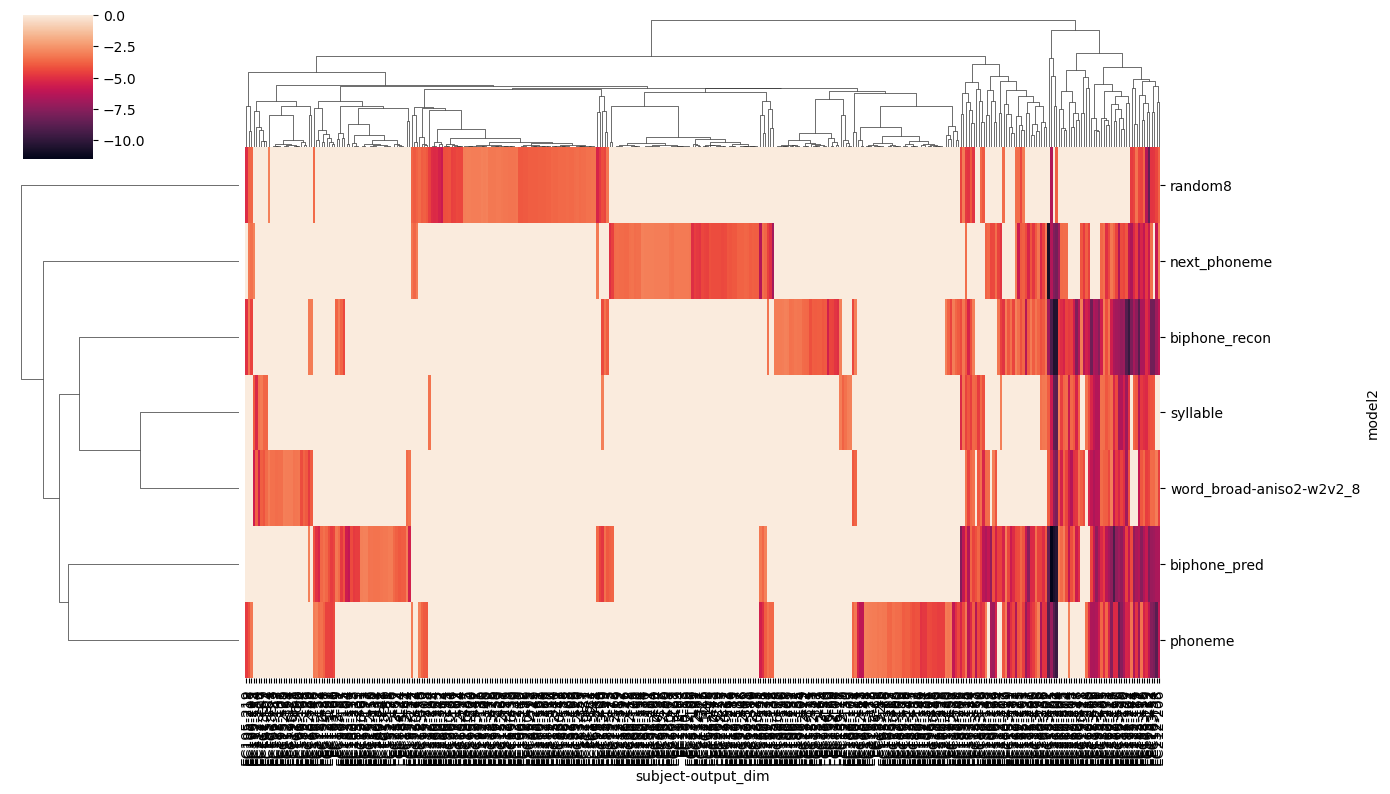

In [41]:
sns.clustermap(log_pvals, vmax=0, xticklabels=1, figsize=(14, 8))

## Colocation

### Colocation of baseline predictiveness and model improvement

In [80]:
score_relationship = scores_df.assign(model=scores_df.model.replace({model_name: "full_model" for model_name in set(scores_df.model) - {"baseline"}})) \
    .reset_index().pivot(index=["subject", "model2", "output_dim", "fold"], columns="model", values="score")
score_relationship

model                                             baseline  full_model
subject model2                   output_dim fold                      
EC152   biphone_pred             0          0    -0.001135   -0.002955
                                            1    -0.001564   -0.003977
                                            2    -0.007084   -0.008600
                                 1          0     0.001129    0.001012
                                            1     0.002411    0.002098
...                                                    ...         ...
EC260   word_broad-aniso2-w2v2_8 254        1     0.061153    0.060345
                                            2     0.047459    0.047571
                                 255        0     0.076003    0.075873
                                            1     0.055240    0.054914
                                            2     0.046608    0.046319

[34944 rows x 2 columns]

In [81]:
# merge in significance values
score_relationship = pd.merge(
    score_relationship, ttest_filtered_df[["pval"]],
    how="left", left_index=True, right_index=True)
score_relationship["significant_improvement"] = score_relationship.pval < pval_threshold

In [82]:
# merge in electrode ROI information
score_relationship = pd.merge(score_relationship.reset_index(),
                              electrode_df[["roi"]].reset_index(),
                              how="left",
                              left_on=["subject", "output_dim"],
                              right_on=["subject", "electrode_idx"]).drop(columns=["electrode_idx"])

In [87]:
score_relationship

,subject,model2,output_dim,fold,baseline,full_model,pval,significant_improvement,roi
0,EC152,biphone_pred,0,0,-0.001135,-0.002955,NaN,False,middletemporal
1,EC152,biphone_pred,0,1,-0.001564,-0.003977,NaN,False,middletemporal
2,EC152,biphone_pred,0,2,-0.007084,-0.008600,NaN,False,middletemporal
3,EC152,biphone_pred,1,0,0.001129,0.001012,NaN,False,middletemporal
4,EC152,biphone_pred,1,1,0.002411,0.002098,NaN,False,middletemporal
...,...,...,...,...,...,...,...,...,...
34939,EC260,word_broad-aniso2-w2v2_8,254,1,0.061153,0.060345,NaN,False,supramarginal
34940,EC260,word_broad-aniso2-w2v2_8,254,2,0.047459,0.047571,NaN,False,supramarginal
34941,EC260,word_broad-aniso2-w2v2_8,255,0,0.076003,0.075873,NaN,False,supramarginal
34942,EC260,word_broad-aniso2-w2v2_8,255,1,0.055240,0.054914,NaN,False,supramarginal


In [116]:
score_relationship[score_relationship.significant_improvement].roi.value_counts()

roi
superiortemporal        1377
middletemporal           261
supramarginal            165
precentral               162
postcentral              144
parsopercularis           57
parstriangularis          33
caudalmiddlefrontal       30
inferiortemporal          30
rostralmiddlefrontal      15
lateraloccipital          12
inferiorparietal           9
Name: count, dtype: int64

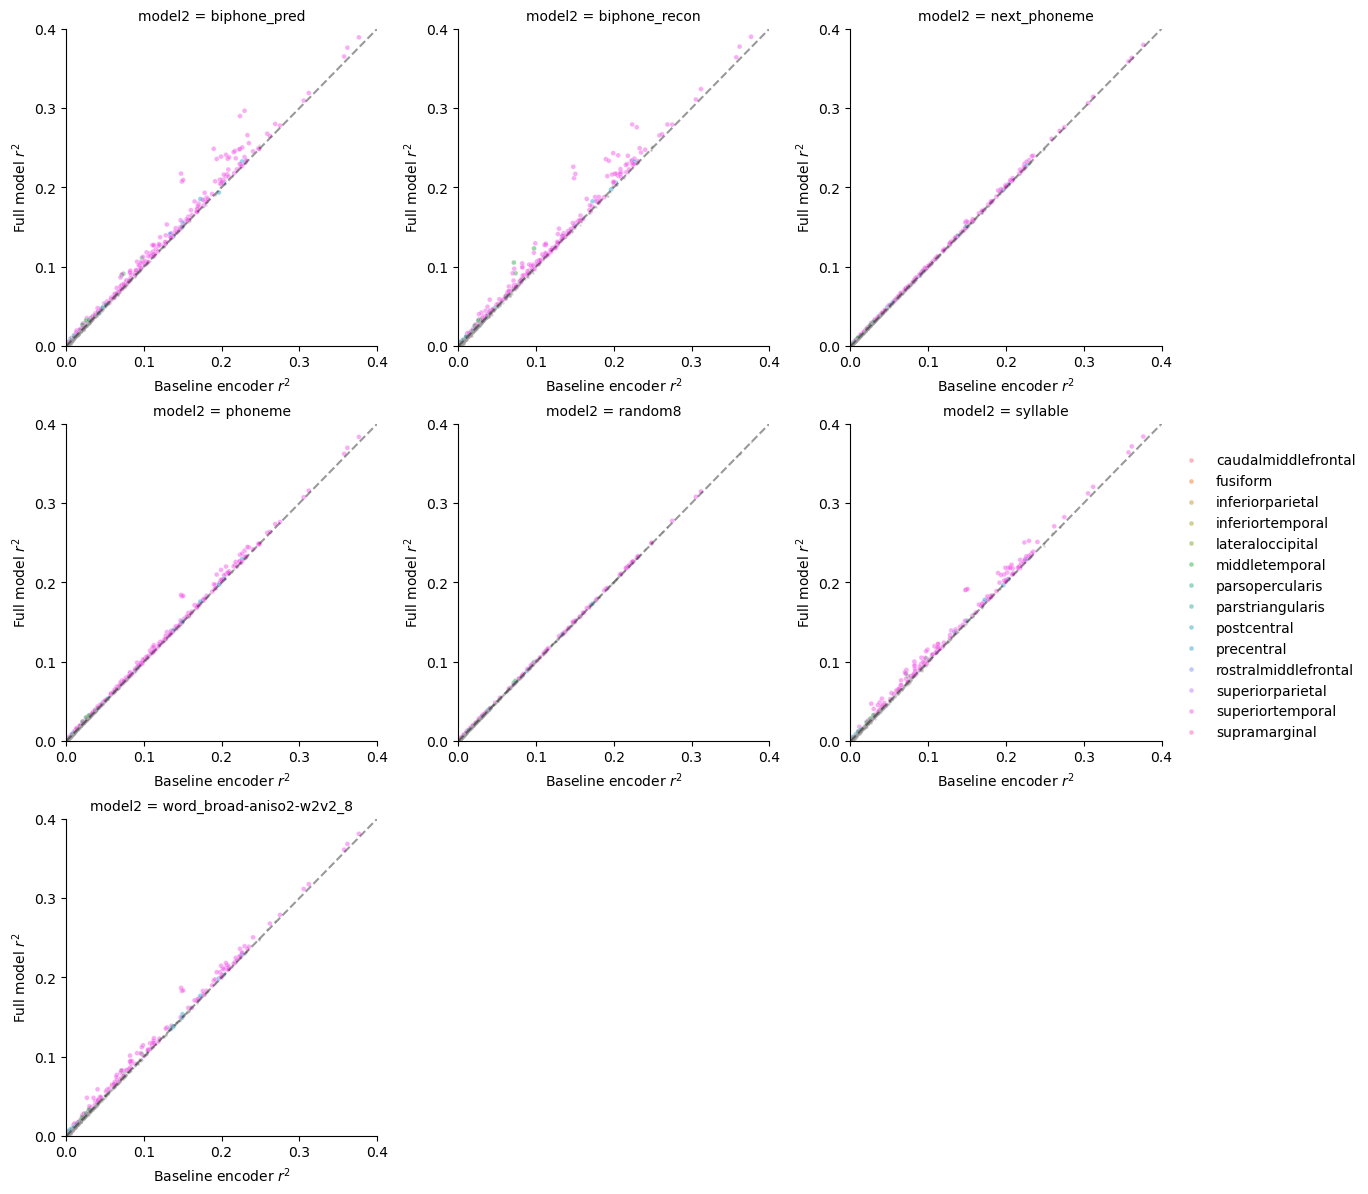

In [122]:
# manually FacetGrid so we can plot two disjoint parts of score_relationship -- those which are not
# significant, and those which are
g = sns.FacetGrid(data=score_relationship.reset_index(),
                  col="model2", col_wrap=3, sharex=False, sharey=False, height=4)

# prepare ROI hues
hue_order = sorted(score_relationship.roi.unique())

def plot_significant_elecs(data, **kwargs):
    ax = plt.gca()
    sns.scatterplot(data=data[data.significant_improvement],
                    x="baseline", y="full_model", hue="roi", hue_order=hue_order,\
                    alpha=0.5, s=12, ax=ax)
    
def plot_nonsignificant_elecs(data, **kwargs):
    ax = plt.gca()
    sns.scatterplot(data=data[~data.significant_improvement],
                    x="baseline", y="full_model", color="gray",
                    alpha=0.3, s=3, ax=ax)

g.map_dataframe(plot_significant_elecs)
g.map_dataframe(plot_nonsignificant_elecs)
g.add_legend()

ax_min = 0.
ax_max = score_relationship[["baseline", "full_model"]].max().max() + 0.01
for ax in g.axes.ravel():
    ax.plot([0, 1], [0, 1], color="black", linestyle="--", alpha=0.4)
    ax.set_xlim(ax_min, ax_max)
    ax.set_ylim(ax_min, ax_max)

    ticks = (np.linspace(ax_min, ax_max, 5) * 10).round() / 10.
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xlabel("Baseline encoder $r^2$")
    ax.set_ylabel("Full model $r^2$")

### Colocation of model embedding and baseline predictivity

In [44]:
speech_responsive_threshold = 0.01
speech_responsive_electrodes = baseline_scores.groupby(["subject", "output_dim"]).score.mean()
speech_responsive_electrodes = speech_responsive_electrodes[speech_responsive_electrodes >= speech_responsive_threshold].index
speech_responsive_electrodes

MultiIndex([('EC152',  52),
            ('EC152',  67),
            ('EC152', 100),
            ('EC152', 101),
            ('EC152', 116),
            ('EC152', 117),
            ('EC152', 118),
            ('EC152', 132),
            ('EC152', 133),
            ('EC152', 135),
            ...
            ('EC260', 232),
            ('EC260', 233),
            ('EC260', 234),
            ('EC260', 235),
            ('EC260', 237),
            ('EC260', 238),
            ('EC260', 239),
            ('EC260', 253),
            ('EC260', 254),
            ('EC260', 255)],
           names=['subject', 'output_dim'], length=216)

In [45]:
model_embedding_improvements = (score_relationship.full_model - score_relationship.baseline).unstack("model2").groupby(["subject", "output_dim"]).mean()
# not interested in overfit electrodes
model_embedding_improvements[model_embedding_improvements < 0] = np.nan
model_embedding_improvements

model2              biphone_pred  biphone_recon  next_phoneme   phoneme  \
subject output_dim                                                        
EC152   0                    NaN            NaN           NaN       NaN   
        1                    NaN       0.000612           NaN  0.000164   
        2                    NaN            NaN      0.000068       NaN   
        3                    NaN            NaN           NaN       NaN   
        4                    NaN            NaN           NaN       NaN   
...                          ...            ...           ...       ...   
EC260   251             0.000255            NaN           NaN  0.000210   
        252                  NaN            NaN           NaN       NaN   
        253                  NaN            NaN      0.000088       NaN   
        254                  NaN            NaN           NaN       NaN   
        255                  NaN            NaN      0.000161       NaN   

model2               random8  syllable  word_broad-aniso2-w2v2_8  
subject output_dim                                                
EC152   0                NaN       NaN                       NaN  
        1           0.000070       NaN                   0.00027  
        2                NaN       NaN                       NaN  
        3           0.000106       NaN                       NaN  
        4           0.000073       NaN                       NaN  
...                      ...       ...                       ...  
EC260   251              NaN       NaN                       NaN  
        252              NaN       NaN                       NaN  
        253         0.000209       NaN                       NaN  
        254         0.000347       NaN                       NaN  
        255         0.000348       NaN                       NaN  

[1664 rows x 7 columns]

In [46]:
baseline_feature_improvements = unique_variance.unstack("dropped_feature").groupby(["subject", "output_dim"]).mean()
# not interested in overfit electrodes
baseline_feature_improvements[baseline_feature_improvements < 0] = np.nan
baseline_feature_improvements

dropped_feature           F0  formantMedOnset    maxDtL     onset  \
subject output_dim                                                  
EC152   0           0.000702              NaN       NaN  0.000008   
        1                NaN         0.000245       NaN       NaN   
        2           0.002554              NaN       NaN       NaN   
        3                NaN              NaN       NaN  0.000046   
        4                NaN              NaN  0.000065       NaN   
...                      ...              ...       ...       ...   
EC260   251              NaN              NaN  0.000011       NaN   
        252         0.001315              NaN       NaN  0.000096   
        253         0.013847         0.000178  0.000032  0.000444   
        254         0.026141         0.000182  0.000012  0.000928   
        255         0.026798         0.000484  0.000033  0.001020   

dropped_feature     phnfeatConsOnset  
subject output_dim                    
EC152   0                   0.000508  
        1                        NaN  
        2                        NaN  
        3                   0.000317  
        4                   0.000164  
...                              ...  
EC260   251                      NaN  
        252                 0.000199  
        253                 0.001263  
        254                 0.001257  
        255                 0.001861  

[1664 rows x 5 columns]

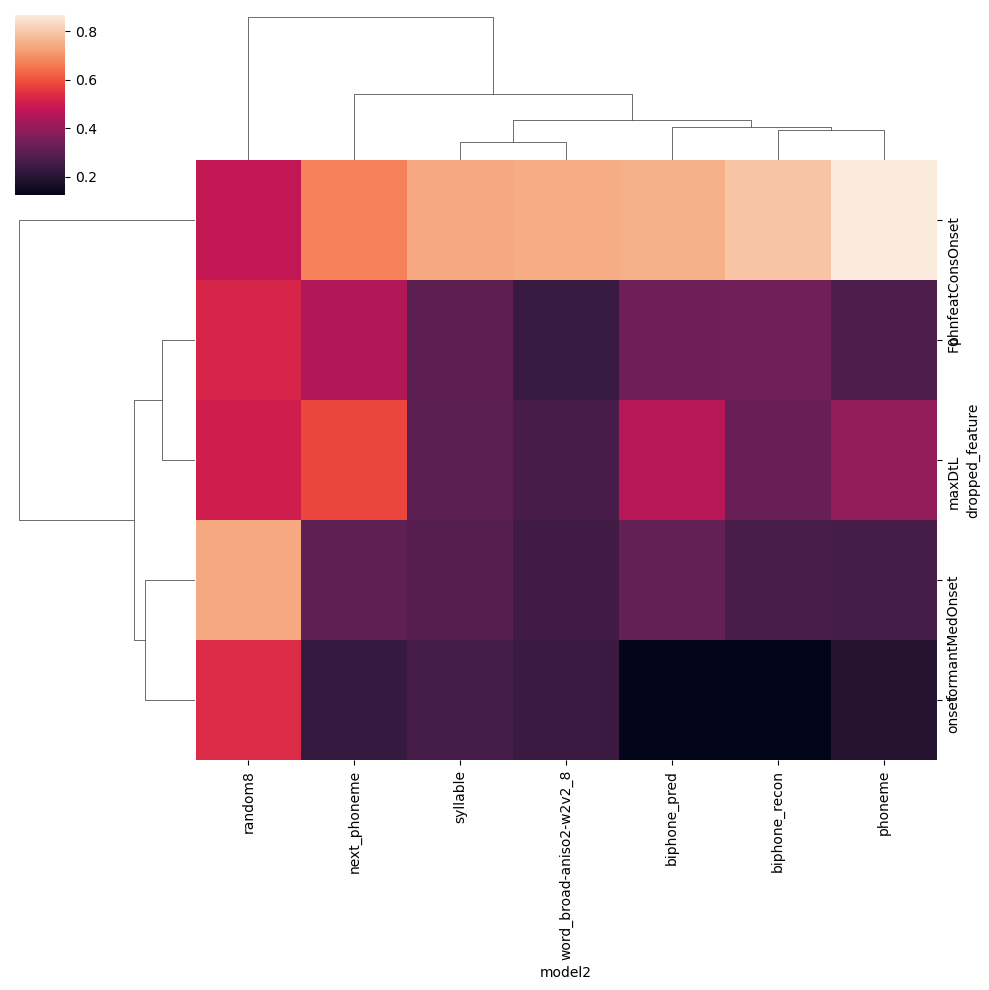

In [47]:
sns.clustermap(pd.concat([model_embedding_improvements, baseline_feature_improvements], axis=1)
                 .corr().loc[baseline_feature_improvements.columns, model_embedding_improvements.columns])

In [48]:
all_improvements = pd.merge(baseline_feature_improvements, model_embedding_improvements,
                            left_index=True, right_index=True, how="left", validate="one_to_one")

In [49]:
all_improvements

F0  formantMedOnset    maxDtL     onset  \
subject output_dim                                                  
EC152   0           0.000702              NaN       NaN  0.000008   
        1                NaN         0.000245       NaN       NaN   
        2           0.002554              NaN       NaN       NaN   
        3                NaN              NaN       NaN  0.000046   
        4                NaN              NaN  0.000065       NaN   
...                      ...              ...       ...       ...   
EC260   251              NaN              NaN  0.000011       NaN   
        252         0.001315              NaN       NaN  0.000096   
        253         0.013847         0.000178  0.000032  0.000444   
        254         0.026141         0.000182  0.000012  0.000928   
        255         0.026798         0.000484  0.000033  0.001020   

                    phnfeatConsOnset  biphone_pred  biphone_recon  \
subject output_dim                                                  
EC152   0                   0.000508           NaN            NaN   
        1                        NaN           NaN       0.000612   
        2                        NaN           NaN            NaN   
        3                   0.000317           NaN            NaN   
        4                   0.000164           NaN            NaN   
...                              ...           ...            ...   
EC260   251                      NaN      0.000255            NaN   
        252                 0.000199           NaN            NaN   
        253                 0.001263           NaN            NaN   
        254                 0.001257           NaN            NaN   
        255                 0.001861           NaN            NaN   

                    next_phoneme   phoneme   random8  syllable  \
subject output_dim                                               
EC152   0                    NaN       NaN       NaN       NaN   
        1                    NaN  0.000164  0.000070       NaN   
        2               0.000068       NaN       NaN       NaN   
        3                    NaN       NaN  0.000106       NaN   
        4                    NaN       NaN  0.000073       NaN   
...                          ...       ...       ...       ...   
EC260   251                  NaN  0.000210       NaN       NaN   
        252                  NaN       NaN       NaN       NaN   
        253             0.000088       NaN  0.000209       NaN   
        254                  NaN       NaN  0.000347       NaN   
        255             0.000161       NaN  0.000348       NaN   

                    word_broad-aniso2-w2v2_8  
subject output_dim                            
EC152   0                                NaN  
        1                            0.00027  
        2                                NaN  
        3                                NaN  
        4                                NaN  
...                                      ...  
EC260   251                              NaN  
        252                              NaN  
        253                              NaN  
        254                              NaN  
        255                              NaN  

[1664 rows x 12 columns]

In [50]:
# represent improvement within each model as % of maximum unique variance
all_improvements_relative = all_improvements.apply(lambda xs: xs.div(xs.groupby("subject").agg(lambda ys: ys.max() - ys.min()).sub(xs.groupby("subject").min())), axis=0)
all_improvements_relative

F0  formantMedOnset    maxDtL     onset  \
subject output_dim                                                  
EC152   0           0.003180              NaN       NaN  0.008600   
        1                NaN         0.027451       NaN       NaN   
        2           0.011574              NaN       NaN       NaN   
        3                NaN              NaN       NaN  0.047336   
        4                NaN              NaN  0.049634       NaN   
...                      ...              ...       ...       ...   
EC260   251              NaN              NaN  0.021173       NaN   
        252         0.018302              NaN       NaN  0.042408   
        253         0.192708         0.044898  0.063529  0.196928   
        254         0.363800         0.045928  0.023405  0.411143   
        255         0.372945         0.122268  0.066325  0.451877   

                    phnfeatConsOnset  biphone_pred  biphone_recon  \
subject output_dim                                                  
EC152   0                   0.033561           NaN            NaN   
        1                        NaN           NaN       0.012418   
        2                        NaN           NaN            NaN   
        3                   0.020961           NaN            NaN   
        4                   0.010855           NaN            NaN   
...                              ...           ...            ...   
EC260   251                      NaN      0.004092            NaN   
        252                 0.002781           NaN            NaN   
        253                 0.017637           NaN            NaN   
        254                 0.017553           NaN            NaN   
        255                 0.025983           NaN            NaN   

                    next_phoneme   phoneme   random8  syllable  \
subject output_dim                                               
EC152   0                    NaN       NaN       NaN       NaN   
        1                    NaN  0.016609  0.032064       NaN   
        2               0.011792       NaN       NaN       NaN   
        3                    NaN       NaN  0.048632       NaN   
        4                    NaN       NaN  0.033644       NaN   
...                          ...       ...       ...       ...   
EC260   251                  NaN  0.006161       NaN       NaN   
        252                  NaN       NaN       NaN       NaN   
        253             0.011968       NaN  0.126914       NaN   
        254                  NaN       NaN  0.211267       NaN   
        255             0.021858       NaN  0.211773       NaN   

                    word_broad-aniso2-w2v2_8  
subject output_dim                            
EC152   0                                NaN  
        1                           0.025573  
        2                                NaN  
        3                                NaN  
        4                                NaN  
...                                      ...  
EC260   251                              NaN  
        252                              NaN  
        253                              NaN  
        254                              NaN  
        255                              NaN  

[1664 rows x 12 columns]

In [51]:
all_improvements_relative.sort_values("word_broad-aniso2-w2v2_8", ascending=False)

F0  formantMedOnset    maxDtL     onset  \
subject output_dim                                                  
EC183   151              NaN         0.391300  0.018297  0.046420   
EC196   119         0.495085         0.471999  0.549020  0.224655   
EC212   201         0.560715         0.028004  0.115699  0.199034   
EC195   122         0.149553              NaN  0.132927  0.994558   
EC260   206         0.533463         0.985840  0.999242  0.323869   
...                      ...              ...       ...       ...   
        251              NaN              NaN  0.021173       NaN   
        252         0.018302              NaN       NaN  0.042408   
        253         0.192708         0.044898  0.063529  0.196928   
        254         0.363800         0.045928  0.023405  0.411143   
        255         0.372945         0.122268  0.066325  0.451877   

                    phnfeatConsOnset  biphone_pred  biphone_recon  \
subject output_dim                                                  
EC183   151                 0.282339      0.304929       0.650438   
EC196   119                 0.757239      1.018974       1.004505   
EC212   201                 1.001006      1.000515       1.000225   
EC195   122                 0.192002      0.345321       0.556925   
EC260   206                 1.000509      1.000356       1.000091   
...                              ...           ...            ...   
        251                      NaN      0.004092            NaN   
        252                 0.002781           NaN            NaN   
        253                 0.017637           NaN            NaN   
        254                 0.017553           NaN            NaN   
        255                 0.025983           NaN            NaN   

                    next_phoneme   phoneme   random8  syllable  \
subject output_dim                                               
EC183   151             0.255768  0.342397  0.138354  1.002302   
EC196   119             0.123000  0.227251  0.884582  1.000509   
EC212   201             1.000046  1.000115  0.560135  1.000295   
EC195   122             0.344677  0.307130  0.307029  0.868894   
EC260   206             1.000115  1.000095  1.000055  1.000256   
...                          ...       ...       ...       ...   
        251                  NaN  0.006161       NaN       NaN   
        252                  NaN       NaN       NaN       NaN   
        253             0.011968       NaN  0.126914       NaN   
        254                  NaN       NaN  0.211267       NaN   
        255             0.021858       NaN  0.211773       NaN   

                    word_broad-aniso2-w2v2_8  
subject output_dim                            
EC183   151                         1.001445  
EC196   119                         1.001220  
EC212   201                         1.001097  
EC195   122                         1.000867  
EC260   206                         1.000782  
...                                      ...  
        251                              NaN  
        252                              NaN  
        253                              NaN  
        254                              NaN  
        255                              NaN  

[1664 rows x 12 columns]

### Colocation study by $p$-value

In [52]:
ttest_df

Unnamed: 4 permutation  \
subject model2                   model1   output_dim                           
EC152   random8                  baseline 165                  0       shift   
                                          116                  1       shift   
                                          129                  2       shift   
                                          133                  3       shift   
                                          101                  4       shift   
...                                                          ...         ...   
EC260   word_broad-aniso2-w2v2_8 baseline 169                107       shift   
                                          191                108       shift   
                                          94                 109       shift   
                                          114                110       shift   
                                          219                111       units   

                                                           tval          pval  \
subject model2                   model1   output_dim                            
EC152   random8                  baseline 165         64.420931  3.478131e-07   
                                          116         20.962180  3.060871e-05   
                                          129         20.348246  3.444157e-05   
                                          133         20.327161  3.458355e-05   
                                          101         19.955432  3.721096e-05   
...                                                         ...           ...   
EC260   word_broad-aniso2-w2v2_8 baseline 169          1.025800  3.629666e-01   
                                          191          0.871193  4.328148e-01   
                                          94          -0.734340  5.034666e-01   
                                          114         -0.056520  9.576384e-01   
                                          219         -0.001985  9.985112e-01   

                                                      log_pval  
subject model2                   model1   output_dim            
EC152   random8                  baseline 165        -6.458654  
                                          116        -4.514155  
                                          129        -4.462917  
                                          133        -4.461130  
                                          101        -4.429329  
...                                                        ...  
EC260   word_broad-aniso2-w2v2_8 baseline 169        -0.440133  
                                          191        -0.363698  
                                          94         -0.298029  
                                          114        -0.018798  
                                          219        -0.000647  

[6378 rows x 5 columns]

In [53]:
# get least-significant p-value result per model -- electrode
electrode_pvals = ttest_df.loc[(slice(None), slice(None), "baseline"), "log_pval"].groupby(["model2", "subject", "output_dim"]).max()
# insert zero pvals for missing model--electrode combinations
electrode_pvals = electrode_pvals.reindex(pd.MultiIndex.from_tuples([(model, subject, output_dim)
                                                                     for subject, output_dim in electrode_df.index
                                                                     for model in study_models], names=["model2", "subject", "output_dim"])) \
    .fillna(0.)
electrode_pvals

model2                    subject  output_dim
random8                   EC195    0            -0.589253
phoneme                   EC195    0             0.000000
biphone_pred              EC195    0             0.000000
biphone_recon             EC195    0             0.000000
next_phoneme              EC195    0            -0.417268
                                                   ...   
biphone_pred              EC152    327           0.000000
biphone_recon             EC152    327           0.000000
next_phoneme              EC152    327           0.000000
syllable                  EC152    327           0.000000
word_broad-aniso2-w2v2_8  EC152    327           0.000000
Name: log_pval, Length: 14112, dtype: float64

In [226]:
contrasts = {
    "word_dominant": (["word_broad-aniso2-w2v2_8"], ["phoneme", "biphone_pred", "biphone_recon"]),
    # "biphone_dominant": (["biphone_pred", "biphone_recon"], ["word_broad-aniso2-w2v2_8", "phoneme"]),
    "biphone_pred_dominant": (["biphone_pred"], ["biphone_recon", "word_broad-aniso2-w2v2_8", "phoneme"]),
    "biphone_recon_dominant": (["biphone_recon"], ["biphone_pred", "word_broad-aniso2-w2v2_8", "phoneme"]),
}

In [228]:
contrast_outcomes = {}
for contrast_name, (positive_models, negative_models) in tqdm(contrasts.items()):
    contrast_outcomes_i = electrode_pvals.groupby(["subject", "output_dim"]).apply(
        lambda xs: xs.loc[positive_models].min() - xs.loc[negative_models].min()) \
        .sort_values(ascending=True) \
        .rename("contrast_value").to_frame()
    contrast_outcomes_i["positive_pval"] = electrode_pvals.loc[positive_models].groupby(["subject", "output_dim"]).min()
    contrast_outcomes[contrast_name] = contrast_outcomes_i
contrast_outcomes = pd.concat(contrast_outcomes, names=["contrast"])
contrast_outcomes

  0%|          | 0/3 [00:00<?, ?it/s]

contrast_value  positive_pval
contrast               subject output_dim                               
word_dominant          EC212   220              -4.170811      -5.474724
                       EC183   9                -4.087660      -4.087660
                       EC212   107              -3.886731      -3.886731
                       EC152   154              -3.849313      -3.849313
                       EC212   143              -3.527993      -3.527993
...                                                   ...            ...
biphone_recon_dominant EC152   225               5.064528       0.000000
                       EC212   157               5.324847       0.000000
                       EC195   154               5.526476       0.000000
                       EC183   194               5.952112       0.000000
                       EC152   13                6.099080       0.000000

[6048 rows x 2 columns]

In [229]:
spotlight_results = {}
for contrast, outcomes_i in contrast_outcomes.groupby("contrast"):
    outcomes_i["outcome"] = None
    outcomes_i.loc[(outcomes_i.positive_pval <= -2) & (outcomes_i.contrast_value <= -1), "outcome"] = "positive"
    outcomes_i.loc[(outcomes_i.positive_pval <= -2) & (outcomes_i.contrast_value >= 1), "outcome"] = "negative"
    outcomes_i.loc[(outcomes_i.positive_pval <= -2) & (outcomes_i.contrast_value.abs() <= 0.5), "outcome"] = "balanced"
    spotlight_results[contrast] = outcomes_i
spotlight_results = pd.concat(spotlight_results.values())

In [230]:
# pivot outcome to columns
spotlight_results_pivot = spotlight_results.reset_index().pivot(index=["subject", "output_dim"], columns="contrast", values=["outcome", "contrast_value"])
spotlight_results_pivot = spotlight_results_pivot[~spotlight_results_pivot.outcome.isna().all(axis=1)]
spotlight_results_pivot

outcome                                       \
contrast           biphone_pred_dominant biphone_recon_dominant word_dominant   
subject output_dim                                                              
EC152   10                          None               balanced          None   
        17                          None               balanced          None   
        20                      balanced                   None          None   
        24                      balanced                   None          None   
        26                          None                   None      positive   
...                                  ...                    ...           ...   
EC260   237                     negative                   None          None   
        238                     negative               negative      negative   
        239                         None               negative          None   
        247                     negative               positive      negative   
        251                     positive                   None          None   

                          contrast_value                                       
contrast           biphone_pred_dominant biphone_recon_dominant word_dominant  
subject output_dim                                                             
EC152   10                      1.987015               0.069366       2.70186  
        17                      1.082134               0.037649      2.652751  
        20                      0.291655                3.17377       3.17377  
        24                     -0.237015               0.925275      3.647258  
        26                      2.159247               2.159247     -2.159247  
...                                  ...                    ...           ...  
EC260   237                     2.003645              -0.731773      0.731773  
        238                     1.974757               2.351245      3.578222  
        239                     0.861643               1.302628      3.893091  
        247                     1.462011              -1.462011      3.028759  
        251                    -1.178584               3.388508      3.388508  

[297 rows x 6 columns]

In [232]:
spotlight_results_pivot.outcome.biphone_pred_dominant.fillna("None").str.cat(spotlight_results_pivot.outcome.biphone_recon_dominant.fillna("None"), sep=" / ") \
    .rename("pred / recon - dominant").value_counts()

pred / recon - dominant
None / None            70
positive / None        49
None / positive        47
balanced / None        23
balanced / balanced    19
None / balanced        18
positive / negative    14
negative / None        13
negative / negative    12
negative / positive    11
None / negative        10
balanced / negative     9
negative / balanced     2
Name: count, dtype: int64

In [220]:
spotlight_results_pivot.loc["EC212"].sort_values(("contrast_value", "word_dominant"))

outcome                 contrast_value              
contrast   biphone_dominant word_dominant biphone_dominant word_dominant
output_dim                                                              
220                    None      positive         4.170811     -4.170811
107                    None      positive         3.886731     -3.886731
143                    None      positive         3.527993     -3.527993
368                    None      positive         3.335317     -3.335317
369                    None      positive          3.11332     -2.811692
...                     ...           ...              ...           ...
301                positive          None        -4.659661      4.659661
231                positive      negative         -1.56576       4.76612
186                balanced          None        -0.498181      5.167442
157                positive          None        -1.742942      5.324847
202                positive      negative        -4.320372       5.61309

[61 rows x 4 columns]

In [59]:
spotlight_results.loc["EC260"]

,word_contrast,log_pval,type
output_dim,,,
125,-2.825540,-2.825540,word_dominant
166,-2.757147,-2.757147,word_dominant
20,-2.466783,-2.466783,word_dominant
180,-2.207506,-2.207506,word_dominant
3,-2.204076,-2.204076,word_dominant
84,-2.144309,-2.144309,word_dominant
173,-2.143487,-2.143487,word_dominant
109,-1.249142,-2.721504,word_dominant
165,-1.049145,-2.858787,word_dominant


In [240]:
spotlight_results.loc[("biphone_pred_dominant", ["EC212", "EC260"]), :].sort_values("contrast_value").head(20)

contrast_value  positive_pval  \
contrast              subject output_dim                                  
biphone_pred_dominant EC212   301              -4.659661      -4.659661   
                              87               -3.622035      -3.622035   
                              164              -2.918958      -2.918958   
                              295              -2.899725      -2.899725   
                      EC260   211              -2.871114      -2.871114   
                      EC212   172              -2.643626      -3.754051   
                              60               -2.638779      -2.638779   
                      EC260   175              -2.538655      -2.538655   
                      EC212   47               -2.442573      -2.442573   
                              291              -2.430845      -2.430845   
                              284              -2.289952      -2.837407   
                      EC260   129              -2.188720      -2.188720   
                      EC212   258              -2.125840      -2.273481   
                      EC260   218              -2.037551      -4.722915   
                      EC212   266              -2.026489      -2.026489   
                              233              -1.947049      -6.188226   
                              25               -1.893876      -1.893876   
                      EC260   234              -1.818082      -3.389889   
                      EC212   157              -1.742942      -5.324847   
                              209              -1.599146      -4.509030   

                                           outcome  
contrast              subject output_dim            
biphone_pred_dominant EC212   301         positive  
                              87          positive  
                              164         positive  
                              295         positive  
                      EC260   211         positive  
                      EC212   172         positive  
                              60          positive  
                      EC260   175         positive  
                      EC212   47          positive  
                              291         positive  
                              284         positive  
                      EC260   129         positive  
                      EC212   258         positive  
                      EC260   218         positive  
                      EC212   266         positive  
                              233         positive  
                              25              None  
                      EC260   234         positive  
                      EC212   157         positive  
                              209         positive

In [234]:
spotlight_results[spotlight_results.outcome == "positive"].groupby(["contrast", "subject"]).size().sort_values(ascending=False)

contrast                subject
biphone_pred_dominant   EC212      19
word_dominant           EC196      18
biphone_recon_dominant  EC183      16
word_dominant           EC212      13
biphone_pred_dominant   EC183      13
                        EC152      11
biphone_recon_dominant  EC195      10
                        EC212      10
                        EC196      10
word_dominant           EC152       9
biphone_pred_dominant   EC195       9
word_dominant           EC260       9
                        EC183       8
biphone_pred_dominant   EC260       7
biphone_recon_dominant  EC152       6
                        EC260       6
biphone_pred_dominant   EC196       4
word_dominant           EC195       1
dtype: int64

In [233]:
spotlight_results.to_csv("spotlight_result.csv")